# Nicholas Koehler presents:
# Forest Fire Prediction, Machine Learning Algorithm
Data located at https://archive.ics.uci.edu/

The data references Montesinho Natural Park in Portugal. The data is a regular CSV file containing various meteorological metrics, along with Fire Weather Index (FWI) features, which are domain-specific features used for rating fire danger. The dataset also contains a column on the area covered by fire for that date (0 if no fires were reported). We will create a prediction algorithm to forecast when a forest fire will occur and how much area it will cover.

In [1]:
# Imports for this notebook
import gc
import os
from typing import List, Tuple, Callable

# Debugger
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


def garbage_collect(vars_):
    for v in vars_:
        if v in globals():
            del globals()[v]
    collected = gc.collect()
    
print(f"The current path for your notebook is:\n {os.getcwd()}\n")
print(f"Your notebook is currently in the following directory:\n {os.path.basename(os.getcwd())}")

The current path for your notebook is:
 C:\Users\leapi\Documents\PersonalProjects\MLA

Your notebook is currently in the following directory:
 MLA


# Here is a snapshot of the data
Pandas data frame format.

In [2]:
forestfire_df = pd.read_csv("forestfires.csv")
display(forestfire_df)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Below is an explanation of each column and a map of the park

### Features
X - x-axis spatial coordinate within the Montesinho Park map: 1 to 9

Y - y-axis spatial coordinate within the Montesinho Park map: 2 to 9

month - month of the year: 'jan' to 'dec'

day - day of the week: 'mon' to 'sun'

FFMC - FFMC index from the FWI system: 18.7 to 96.20

DMC - DMC index from the FWI system: 1.1 to 291.3

DC - DC index from the FWI system: 7.9 to 860.6

ISI - ISI index from the FWI system: 0.0 to 56.10

temp - temperature in degrees Celsius: 2.2 to 33.30

RH - relative humidity in %: 15.0 to 100

wind - wind speed in km/h: 0.40 to 9.40

rain - outside rain in mm/m^2 : 0.0 to 6.4

### Label

area - the burned area of the forest (in ha): 0.00 to 1090.84

##                                                          Map

<img src="https://www.researchgate.net/profile/Paulo-Cortez-4/publication/238767143/figure/fig1/AS:298804772392991@1448252017812/The-map-of-the-Montesinho-natural-park.png">

# Initial Analysis

The first step in developing our algorithm is to look for correlations between our features and our target, which is the area covered by the fire.  To do this, we will plot each feature against the logarithm of the target.  We use the logarithm because it normalizes the data and reduces the effects of outliers.

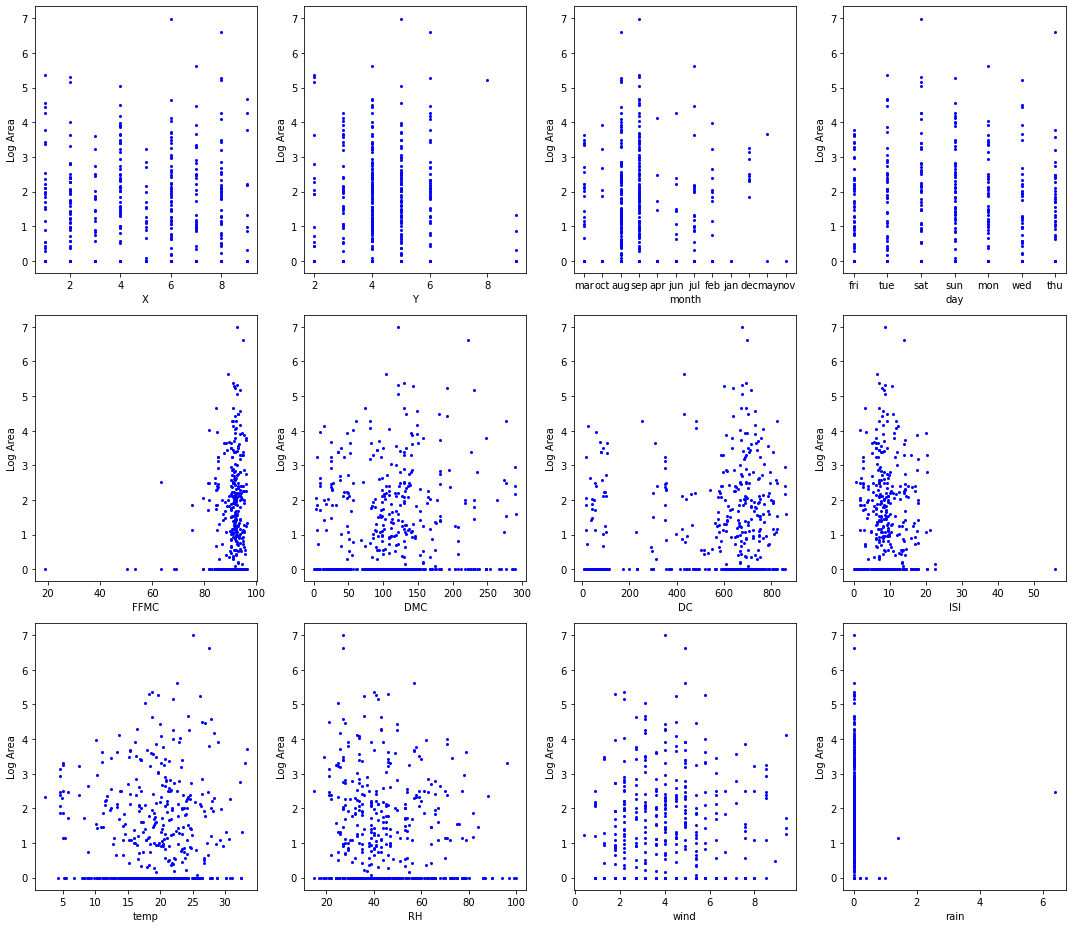

In [4]:
#using numpy
log_area_values = np.log1p(forestfire_df['area'])
features = forestfire_df.iloc[:,0:12]

fig, _ = plt.subplots(figsize=(15, 13))

# column_name holds the current column name
# idx holds the current column index
# You can use either to index features to get the current feature
for idx, column_name in enumerate(features.columns.values):
    # Sets sub-plot index
    plt.subplot(3, 4, idx+1)
    
    plt.plot(features[column_name].values, log_area_values, 'bo', markersize=2)
    
    plt.ylabel('Log Area')
    plt.xlabel(column_name)
    
    
fig.tight_layout()
plt.show()

# How to read this

The Y-axis is always area, meaning a higher Y value means a bigger fire.

Just from observation, it seems like the months Augest and September tend to have more fires happening.  We can also see the presence of several large outliers. Because we will never be able to predict these rare masive fires without more data, we will need to remove them to avoid getting strange errors. We will also be dropping the day column because we can assume that any variance on day of week is due to random chance rather than any real driving factor.

# Data Prep Pipeline

We have several steps to prepare the data before we can use it.

#### 1: pre-split cleaning
#### 2: feature and label splitting and train, validation, and test set splitting
#### 4: Apply post-split cleaning

###### SkLearn
We are using libraries that handle take care of some of these steps, but we want to customize them to our specific needs. We will create wrapper classes to encode these functions.  First, a simple class to make sure our pandas dataframes can work with sklearn's column transformer named DataFrameColumnTransformer.

###### Pre-split Cleaning
In the pre-split phase, we want to implement one-hot encoding for the categorical data (month and day) and a log transformer to the area. We also want to remove the outliers.  After that we make the before_pipeline prep class which just puts all these together.

##### Data Splitting
For the feature and label splitting, as well as the train, validation and test splitting, we are just working with the default functionality and just using the Dataframe conversion class we made earlier.

##### Post-split Cleaning
Finally in the post-split we want to add a bias column and standardize the values.  To standardize the values, subtract the mean from the value, and then divide by the standard deviation: (X  - self.mean) / self.std.  with a post-split wrapper class to apply everything, the functionality for each step is complete.

##### Final pipeline
After that, all that's left to do is create the data_prep class, which just applies all the functions that we just went over.

In [6]:
class DataFrameColumnTransformer(TransformerMixin):
    def __init__(self, stages: List[Tuple]):
        self.col_trans = ColumnTransformer(stages)
    
    def fit(self, X: pd.DataFrame):
        # Runs ColumnTransformer.fit() method 
        self.col_trans.fit(X)
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        # Runs ColumnTransformer.transform() method
        output_arr = self.col_trans.transform(X)
        
        return self.to_dataframe(output_arr)
    
    def to_dataframe(self, arr: np.ndarray) -> pd.DataFrame:
        # Converts our output of ColumnTransformer into a DataFrame
        feature_names = self.col_trans.get_feature_names_out()
        
        # Remove the "__" that ColumnTransformer adds to our feature names
        # when we call self.col_trans.get_feature_names_out()
        for i, name in enumerate(feature_names):
            if '__' in name:
                feature_names[i] = name.split('__', 1)[-1]
        
        # Creates a Pandas Dataframe
        df = pd.DataFrame(arr, columns=feature_names)
        
        return df

### One Hot Encoding

This method takes catagorical data and converts it in to boolean data.  For example consider the month column, which contains string data of which month it is. Using this method we convert this 1 column in to 12 columns, each representing a single month and contain a 1 or 0 representing true or false

In [7]:
class OneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None
    
    def fit(self,
            X: pd.DataFrame, 
            y: pd.DataFrame = None):
        
        # We don't need to set/learn any variables so
        # we just need to return a reference to the object with 'self'
        # If we dont return self the Pipeline class will throw errors
        return self
    
    def transform(self,
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        
        one_hot = pd.get_dummies(X)
        self.feature_names = one_hot.columns
        
        return one_hot
    
    def get_feature_names_out(self, names=None)-> List[str]:
        return list(self.feature_names)

In [8]:
class LogTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.feature_names = None
    
    def fit(self,
            X: pd.DataFrame, 
            y: pd.DataFrame = None):
        
        # We don't need to set/learn any variables so
        # we just need to return a reference to the object with 'self'
        # If we dont return self the Pipeline class will throw errors
        return self
    
    def transform(self,
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        self.feature_names = X.columns
        
        return np.log1p(X)
    
    def get_feature_names_out(self, names=None) -> List[str]:
        return list(self.feature_names)

### Removing Outliers

Outliers are defined as being more then 1.5 times the IQR away from Q1 and Q3. Without more data on how these rare large fires start, our algorithm will never be able to predict them.  In this situation it is better to focus on the standard case for higher average accuracy. 

In [9]:
def remove_outliers_iqr(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for the given column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate IQR (Interquartile Range)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for detecting outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove rows where the column has outliers
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df

In [10]:
def before_pipeline(forestfire_df, remove_outliers = False):
    # Enable by sending remove_outliers = true as a parameter
    if remove_outliers:
        forestfire_df = remove_outliers_iqr(forestfire_df, "area")
    
    passthrough_cols = forestfire_df.drop(['month', 'day', 'area'], axis=1).columns 
    
    # passthrough = do nothing
    stages = [['pass', 'passthrough', passthrough_cols], ['one_hot', OneHotEncoding(), ['month', 'day']], ['log', LogTransformer(), ['area']]]

    # 
    before_pipe = DataFrameColumnTransformer(stages)
    
    # 
    cleaner_df = before_pipe.fit_transform(forestfire_df)
    
    return cleaner_df

In [11]:
def feature_label_split(cleaner_df):
    # X = features
    X = cleaner_df.drop(['area'], axis = 1).copy()
    # y = label
    y = cleaner_df['area'].copy()
    
    return X, y

In [12]:
from sklearn.model_selection import train_test_split 
def train_valid_test_split(X, y):
    # split test off of train
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=.2, random_state=42)
    # split vld off of train
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn,y_trn, test_size=.2, random_state=42)
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [13]:
class AddBias(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None
    
    def fit(self,
            X: pd.DataFrame, 
            y: pd.DataFrame = None) -> pd.DataFrame:
        return self
    
    def transform(self,
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        
        X = X.copy()
        
        X.insert(0, 'bias', 1)
        
        self.feature_names = X.columns
        return X
    
    def get_feature_names_out(self, names=None) -> List[str]:
        return list(self.feature_names)

In [14]:
class Standardization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None
    
    def fit(self,
            X: pd.DataFrame, 
            y: pd.DataFrame = None) -> pd.DataFrame:
        
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self
    
    def transform(self, 
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        self.feature_names = X.columns
        return (X  - self.mean) / self.std

    def get_feature_names_out(self, name=None) -> pd.Series:
        return self.feature_names

In [15]:
def after_pipeline(X_trn, X_vld, X_tst):
    
    stages = [['scaler', Standardization()], ['bias', AddBias()]]
    
    
    after_pipe = Pipeline(stages)
    
    
    X_trn_clean = after_pipe.fit_transform(X_trn)

    X_vld_clean = after_pipe.transform(X_vld)

    X_tst_clean = after_pipe.transform(X_tst)
    
    return X_trn_clean, X_vld_clean, X_tst_clean
    

In [16]:
def data_prep(forestfire_df: pd.DataFrame, 
              return_array: bool = False,
              drop_features: List = None,
             remove_outliers: bool = False) -> Tuple[pd.DataFrame]:
    """ Splits data and runs before and after split data cleaning and transformations
    
        Args:
            forestfire_df: A Pandas DataFrame containing the Forest Fire data
            
            return_array: A boolean which when True will return all data as NumPy
                arrays instead of Pandas DataFrames.
                
            drop_features: List of feature names to drop
    """
    # Apply pre-split cleaning
    cleaner_df = before_pipeline(forestfire_df, remove_outliers)
    # Apply feature and label splitting
    X, y = feature_label_split(cleaner_df)
    # Apply train, validation and test set splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = train_valid_test_split(X, y)
    # Apply post-split cleaning
    X_trn, X_vld, X_tst = after_pipeline(X_trn, X_vld, X_tst)

    # Resets the Pandas index for the Dataframe and series
    # This will prevent any headaches when combining or indexing
    # our train, validation, and test data in the future.
    X_trn.reset_index(inplace=True, drop=True)
    y_trn.reset_index(inplace=True, drop=True)
    X_vld.reset_index(inplace=True, drop=True)
    y_vld.reset_index(inplace=True, drop=True)
    X_tst.reset_index(inplace=True, drop=True)
    y_tst.reset_index(inplace=True, drop=True)
    
    # Drop any features we don't want
    if drop_features is not None:
        X_trn, X_vld, X_tst = (X_trn.drop(drop_features, axis=1),
                               X_vld.drop(drop_features, axis=1),
                               X_tst.drop(drop_features, axis=1))
        
    
    # Return data as arrays instead of DataFrames
    if return_array:
        X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = (X_trn.values, 
                                                    y_trn.values, 
                                                    X_vld.values, 
                                                    y_vld.values, 
                                                    X_tst.values, 
                                                    y_tst.values)
                               
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

## Find the Weights 

Now that the data has been prepared properly, we can create the algorithm.

##### Least Squares Method:
The Least Squares method minimizes the sum of the squares of the differences between the observed values and the predicted values. This approach finds the best-fitting line by ensuring that the total error is as small as possible.  I chose to use least squares because it is straightforward and efficient in handling linear relationships, and simple to implement.  I hope to try out some other regression models soon to build off this project.

In [18]:
class OrdinaryLeastSquares():
    def __init__(self):
        # Initialize the weights to None; they will be computed during fitting
        self.w = None
        
    def fit(self, X, y):
        # finds the weights through OLS
        # w = (X^T * X)^(-1) * X^T * y
        self.w = np.matmul(np.linalg.pinv(np.matmul(X.T,X)),X.T)@y
        
    def predict(self, X):
        # Multiply the feature matrix by the weight vector to get predictions
       #y = X1 * w1 + X2 * w2 + ... + Xn * wn
        y = X@self.w
        return y

## Running the program

Here, we just use all the functions we have implemented in order to actually make the algorithm.

In [32]:
# Make sure everything is fresh
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_vld', 'vld_sse', 'vld_mse', 'vld_rmse', 'data_features'])

# Get our data and return them as NumPy arrays
drop_features = ['day_sat', 'day_tue', 'day_sun', 'day_fri', 'day_wed','day_mon','day_thu'] 

# Data-Prep
X_trn, y_trn, X_vld, y_vld, _, _ = data_prep(forestfire_df, drop_features=drop_features, return_array=True, remove_outliers = True)

# Prep OLS class
ols = OrdinaryLeastSquares()

# Fit our data and learn "best" weights for training data
ols.fit(X_trn, y_trn)

# Check how well our weights learned our training set
y_hat_trn = ols.predict(X_trn)

# Test our algorithm on the validation set
y_hat_vld = OrdinaryLeastSquares.predict(ols, X_vld) 

# Testing

At this point, we have fully implemented our algorithm, and we just need to test it! To do that we need a numerical way to measure the performance, hence performance measure!

### Performance measures
The purpose of each of these measures is to provide a numerical assesment of how accurate the algorithm is. As a reminder, we split the data into three sets: the training set, validation set, and testing set.  We use the training set to obtain the weights, then try it on the validation set, and make any adjustments as needed.  Once we have our preferred model, the last step is to combine the training and validation sets, make one more model, and then run it on the test set to see the final results

##### Error
Error is defined as the set of the predicted target values minus the actual values. Understanding the error helps identify how far off the predictions are from the actual outcomes, providing insight into the algorithm's performance.

##### SSE
SSE stands for sum of squared errors, meaning that it is simply the sum of the squared error set. SSE is useful for quantifying the total error across all predictions, allowing us to understand the model's performance in terms of cumulative error.

##### MSE
MSE stands for Mean Squared Error and is calculated by taking the mean of the squared errors. MSE provides an average error metric that helps to normalize the error across different scales of the target variable, making it easier to compare models.

##### RMSE
RMSE stands for Root Mean Squared Error and is found by taking the square root of the MSE. RMSE offers a measure of error in the same units as the target variable, making it intuitively easier to interpret in the context of the problem.

#### Analyze
This function presents the performance measures and graphs our error per data sample. By visualizing the error, we can better understand how the model performs across different data points and identify any patterns or outliers.

In [33]:
# Analysis tools

def error(y, y_hat):
    # Calculate the difference between predicted and actual values (residuals)
    return y_hat - y

def mse(y, y_hat):
    # Calculate the mean squared error between actual and predicted values
    return np.mean(error(y, y_hat)**2)

def rmse(y, y_hat):
    # Calculate the root mean squared error by taking the square root of the MSE
    return np.sqrt(mse(y, y_hat))

def performance_measures(y: np.ndarray, y_hat: np.ndarray) -> Tuple[np.ndarray]:
    # Compute performance metrics: error, sum of squared errors, MSE, and RMSE
    err = error(y, y_hat)
    sse = np.sum(err**2)
    mse_ = mse(y, y_hat)
    rmse_ = rmse(y, y_hat)
    return err, sse, mse_, rmse_

def unlog(x):
    # Apply inverse log transformation to revert log-transformed values to their original scale
    return np.exp(x) - 1

def analyze(
    y: np.ndarray, 
    y_hat: np.ndarray,
    title: str, 
    dataset: str,
    xlabel: str = None,
    ylabel: str = None
) -> Tuple[np.ndarray]:
    # calculate and Display preformance mesures; and provide data visualization
    
    # Calculate error, SSE, MSE, and RMSE for log-transformed data
    err, sse, mse_, rmse_ = performance_measures(y=y, y_hat=y_hat)
    
    # Apply inverse log transformation to actual values, predictions, and metrics
    y_ha = unlog(y)
    y_hat_ha = unlog(y_hat)   
    mse_ha = unlog(mse_)
    rmse_ha = unlog(rmse_)
    err_ha = unlog(err)
    sse_ha = np.sum(err_ha**2)
    
    # Plot actual vs predicted values on log scale
    plt.plot(y, 'ob')
    plt.plot(y_hat, 'xr')
    plt.xlabel(xlabel)
    plt.ylabel("Log " + ylabel)
    plt.title(title)
    plt.show()
    
    # Plot errors on log scale
    plt.plot(err, 'og')
    plt.xlabel(xlabel)
    plt.ylabel("Log " + ylabel + " Error")
    plt.title("Error")
    plt.show()
    
    # Print statistical information (mean and standard deviation) for log-transformed values
    print(f"Y Mean: {y.mean()}")
    print(f"Y_hat Mean: {y_hat.mean()}")
    print(f"Y std: {y.std()}")
    print(f"Y_hat std: {y_hat.std()}")
    
    # Plot actual vs predicted values after applying inverse log transformation
    plt.plot(y_ha, 'ob')
    plt.plot(y_hat_ha, 'xr')
    plt.xlabel(xlabel)
    plt.ylabel("Hectares " + ylabel)
    plt.title(title)
    plt.show()
    
    # Plot errors after inverse log transformation
    plt.plot(err_ha, 'og')
    plt.xlabel(xlabel)
    plt.ylabel("Hectares " + ylabel + " Error")
    plt.title("Error")
    plt.show()
    
    # Print statistical information (mean and standard deviation) for values in hectares
    print(f"Hectares Y Mean: {y_ha.mean()}")
    print(f"Hectares Y_hat Mean: {y_hat_ha.mean()}")
    print(f"Hectares Y std: {y_ha.std()}")
    print(f"Hectares Y_hat std: {y_hat_ha.std()}")
    
    print("")
    
    # Print MSE, RMSE, and SSE for log-transformed data
    print("Log area")
    print(f"{dataset} MSE: {mse_}")
    print(f"{dataset} RMSE: {rmse_}")
    print(f"{dataset} SSE: {sse}")
    
    print("")
    
    # Print MSE, RMSE, and SSE for data in hectares
    print("Hectares area")
    print(f"Hectares {dataset} MSE: {mse_ha}")
    print(f"Hectares {dataset} RMSE: {rmse_ha}")
    print(f"Hectares {dataset} SSE: {sse_ha}")
    
    # Return the error and performance metrics
    return err, sse, mse_, rmse_

# Train Set

For each of the following graphs, red Xs represent our predicted values, while the blue dots correspond to the actual data points. Additionally, the green dots indicate the error.

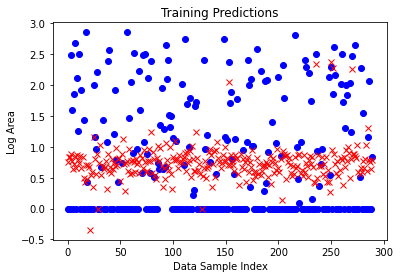

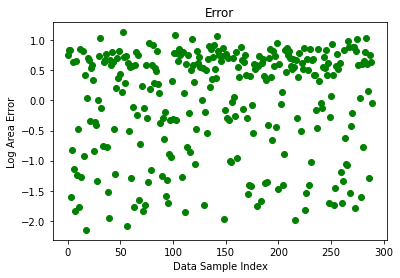

Y Mean: 0.7413989282824891
Y_hat Mean: 0.7413989282824889
Y std: 0.924119630590575
Y_hat std: 0.27859712018478816


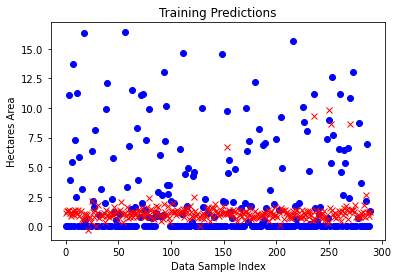

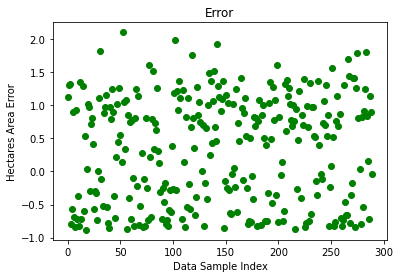

Hectares Y Mean: 2.4221034482758625
Hectares Y_hat Mean: 1.2111471046529696
Hectares Y std: 3.8429662649360306
Hectares Y_hat std: 1.0653089269737348

Log area
Train MSE: 0.7763807362676027
Train RMSE: 0.8811246996127181
Train SSE: 225.1504135176048

Hectares area
Hectares Train MSE: 1.1735912124520547
Hectares Train RMSE: 1.4136127697879899
Hectares Train SSE: 220.96747890502675


In [21]:
trn_scores = performance_measures(y=y_trn, y_hat=y_hat_trn)
trn_error, trn_sse, trn_mse, trn_rmse = trn_scores

trn_scores = analyze(
    y=y_trn,
    y_hat=y_hat_trn,
    title="Training Predictions",
    dataset="Train",
    xlabel="Data Sample Index",
    ylabel="Area")

# Validation Set

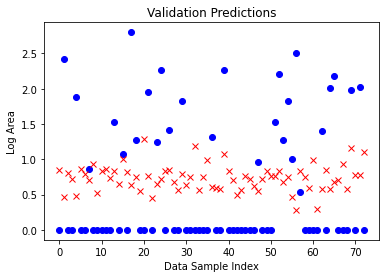

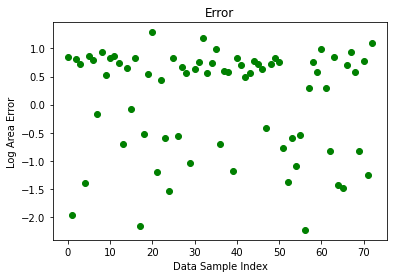

Y Mean: 0.6249518690632975
Y_hat Mean: 0.7352371291919263
Y std: 0.8828110917066296
Y_hat std: 0.18685368492779095


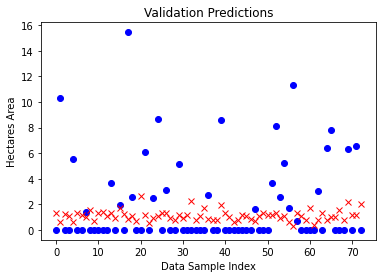

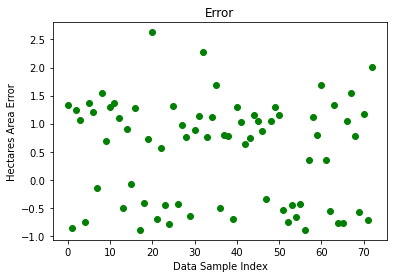

Hectares Y Mean: 1.9575342465753425
Hectares Y_hat Mean: 1.1236338003913062
Hectares Y std: 3.312846221067862
Hectares Y_hat std: 0.4167053280324251

Log area
Validation MSE: 0.8604354708282114
Validation RMSE: 0.9275966099702022
Validation SSE: 62.81178937045943

Hectares area
Hectares Validation MSE: 1.364190005351611
Hectares Validation RMSE: 1.5284250776911126
Hectares Validation SSE: 79.36293722692332


In [22]:
trn_scores = performance_measures(y=y_trn, y_hat=y_hat_trn)
trn_error, trn_sse, trn_mse, trn_rmse = trn_scores


vld_scores = analyze(
    y=y_vld,
    y_hat=y_hat_vld,
    title="Validation Predictions",
    dataset="Validation",
    xlabel="Data Sample Index",
    ylabel="Area")

_, vld_sse, vld_mse, vld_rmse = vld_scores

# Test Set
For the final step, now that the hyperparameters are tuned, we combine the validation and training sets to create a single dataset. Using this combined set, we build one last model to evaluate its performance on unseen data.

In [34]:
garbage_collect(['X_trn', 'y_trn', 'X_vld', 'y_vld','y_hat_trn', 'trn_sse', 'trn_mse', 'trn_rmse', 'y_hat_vld', 'vld_sse', 'vld_mse', 'vld_rmse', 'data_features'])

# Get our data and return them as NumPy arrays
drop_features = ['day_sat', 'day_tue', 'day_sun', 'day_fri', 'day_wed','day_mon','day_thu'] 

# data prep
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = data_prep(forestfire_df, drop_features=drop_features, return_array=True, remove_outliers = True)

# define class
ols = OrdinaryLeastSquares()

# Combine train and validation features
X_combined = np.concatenate([X_trn, X_vld], axis=0)  
# Combine target labels
y_combined = np.concatenate([y_trn, y_vld], axis=0)

# Fit the model
ols.fit(X_combined, y_combined)

# make predictions
y_hat_tst = ols.predict(X_tst)

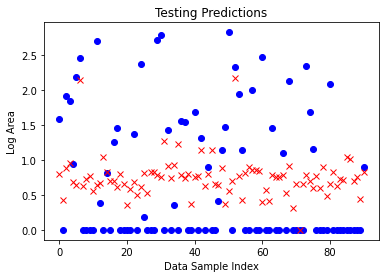

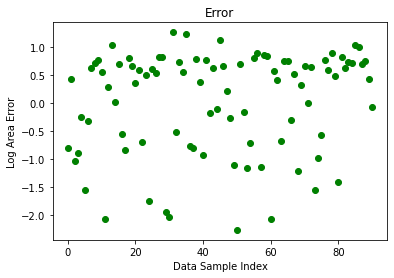

Y Mean: 0.7089971647067602
Y_hat Mean: 0.7525451184480318
Y std: 0.9253458787282353
Y_hat std: 0.28970322474568083


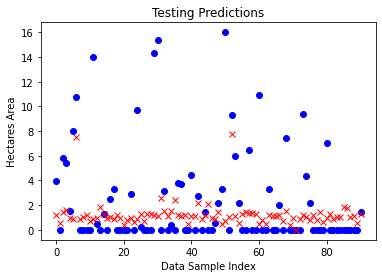

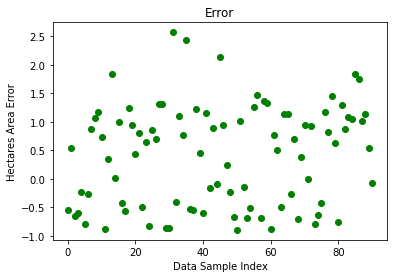

Hectares Y Mean: 2.344175824175824
Hectares Y_hat Mean: 1.242172816300962
Hectares Y std: 3.893923433421565
Hectares Y_hat std: 1.049428489538871

Log area
Testing MSE: 0.8241675160661501
Testing RMSE: 0.9078367232416577
Testing SSE: 74.99924396201966

Hectares area
Hectares Testing MSE: 1.279981926739178
Hectares Testing RMSE: 1.4789540650231343
Hectares Testing SSE: 85.53836703000245


In [35]:
tst_scores = analyze(
    y=y_tst,
    y_hat=y_hat_tst,
    title="Testing Predictions",
    dataset="Testing",
    xlabel="Data Sample Index",
    ylabel="Area")

# Conclusion Analysis

### How did we do?
Overall, we observe that for most of our predictions, our error is within 1.5 hectares which does not seem too bad. One issue we have is the data is heavily skewed to 0, meaning that our algorithm will prefer to predict lower values overall. I have a few ideas for addressing this using a new model.

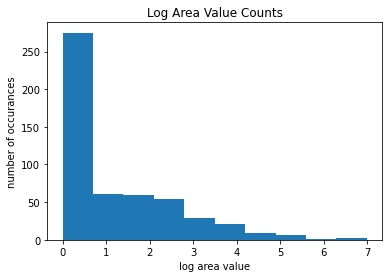

In [29]:
# Apply pre-split cleaning
cleaner_df = before_pipeline(forestfire_df)
# Apply feature and label splitting
X, y = feature_label_split(cleaner_df)

# Plot log area counts
plt.hist(y)
plt.xlabel('log area value')
plt.ylabel('number of occurances')
plt.title("Log Area Value Counts")
plt.show()

del X, y, cleaner_df

## Future plans
We currently have a functioning algorithm; however, there is room for improvement. I plan to continue working with this dataset to develop an algorithm that addresses the far outliers. One approach I'm particularly interested in exploring is quantile regression. I believe this algorithm can effectively handle skewed data by accounting for outliers.  Another aproach would be using a two stage algorithm to first catagoricaly predict if there will be a fire, then if there is a fire, use regresson to predict the area.